# Object Detection Fastai

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and the output is a bounding box and classification of an object.  But before we have this solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

## Data

The data for this notebook comes from the XView competition[].  The data is described here https://arxiv.org/pdf/1802.07856.pdf.  Other interesting satellite image datasets could also be used.  For example:

* spacenet
* COCO

In [2]:
# val data
!aws s3 cp s3://random.datasets.sengstacken/xview_satellite_images/val.tgz ./data/

download: s3://random.datasets.sengstacken/xview_satellite_images/val.tgz to data/val.tgz


In [3]:
!tar -xvzf ./data/val.tgz -C ./data

./val_images/
./val_images/1038.tif
./val_images/1040.tif
./val_images/1043.tif
./val_images/1054.tif
./val_images/1060.tif
./val_images/1062.tif
./val_images/1064.tif
./val_images/1066.tif
./val_images/1069.tif
./val_images/1071.tif
./val_images/1073.tif
./val_images/1075.tif
./val_images/108.tif
./val_images/1082.tif
./val_images/1097.tif
./val_images/1098.tif
./val_images/11.tif
./val_images/1102.tif
./val_images/1115.tif
./val_images/1116.tif
./val_images/1117.tif
./val_images/1122.tif
./val_images/1134.tif
./val_images/1138.tif
./val_images/1148.tif
./val_images/1159.tif
./val_images/1161.tif
./val_images/1177.tif
./val_images/1194.tif
./val_images/12.tif
./val_images/1207.tif
./val_images/121.tif
./val_images/1213.tif
./val_images/122.tif
./val_images/1234.tif
./val_images/1235.tif
./val_images/1254.tif
./val_images/1258.tif
./val_images/1263.tif
./val_images/1267.tif
./val_images/1282.tif
./val_images/1308.tif
./val_images/1326.tif
./val_images/1333.tif
./val_images/1358.tif
./v

In [4]:
# train data
!aws s3 cp s3://random.datasets.sengstacken/xview_satellite_images/train.tgz ./data/

download: s3://random.datasets.sengstacken/xview_satellite_images/train.tgz to data/train.tgz


In [5]:
!tar -xvzf ./data/train.tgz -C ./data/

./train_images/
./train_images/10.tif
./train_images/._100.tif
./train_images/100.tif
./train_images/._102.tif
./train_images/102.tif
./train_images/1036.tif
./train_images/1037.tif
./train_images/104.tif
./train_images/1042.tif
./train_images/1044.tif
./train_images/1046.tif
./train_images/1048.tif
./train_images/1049.tif
./train_images/105.tif
./train_images/1050.tif
./train_images/1051.tif
./train_images/1052.tif
./train_images/1053.tif
./train_images/1056.tif
./train_images/1058.tif
./train_images/106.tif
./train_images/1061.tif
./train_images/1063.tif
./train_images/1065.tif
./train_images/1067.tif
./train_images/1068.tif
./train_images/107.tif
./train_images/1070.tif
./train_images/1072.tif
./train_images/1076.tif
./train_images/1077.tif
./train_images/1079.tif
./train_images/1080.tif
./train_images/1081.tif
./train_images/1084.tif
./train_images/1085.tif
./train_images/1086.tif
./train_images/1087.tif
./train_images/1088.tif
./train_images/1089.tif
./train_images/._109.tif
./tra

In [6]:
# train labels
!aws s3 cp s3://random.datasets.sengstacken/xview_satellite_images/train_labels.tgz ./data/

download: s3://random.datasets.sengstacken/xview_satellite_images/train_labels.tgz to data/train_labels.tgz


In [4]:
!tar -xvzf ./data/train_labels.tgz -C ./data/

./xView_train.geojson


## Data Preparation

In [54]:
from fastai.vision import *
from fastai import *

In [4]:
!wget https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz

--2020-04-08 21:29:25--  https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.12.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.12.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3245877008 (3.0G) [application/x-tar]
Saving to: ‘coco_sample.tgz’

coco_sample.tgz     100%[===================>]   3.02G  34.9MB/s    in 79s     

2020-04-08 21:30:44 (39.3 MB/s) - ‘coco_sample.tgz’ saved [3245877008/3245877008]



In [7]:
!tar -xvzf coco_sample.tgz

coco_sample/
coco_sample/annotations/
coco_sample/annotations/train_sample.json
coco_sample/train_sample/
coco_sample/train_sample/000000523978.jpg
coco_sample/train_sample/000000540498.jpg
coco_sample/train_sample/000000012307.jpg
coco_sample/train_sample/000000397138.jpg
coco_sample/train_sample/000000374598.jpg
coco_sample/train_sample/000000222500.jpg
coco_sample/train_sample/000000290798.jpg
coco_sample/train_sample/000000231091.jpg
coco_sample/train_sample/000000113588.jpg
coco_sample/train_sample/000000327788.jpg
coco_sample/train_sample/000000546934.jpg
coco_sample/train_sample/000000419019.jpg
coco_sample/train_sample/000000039513.jpg
coco_sample/train_sample/000000311066.jpg
coco_sample/train_sample/000000373015.jpg
coco_sample/train_sample/000000329613.jpg
coco_sample/train_sample/000000069214.jpg
coco_sample/train_sample/000000152871.jpg
coco_sample/train_sample/000000271396.jpg
coco_sample/train_sample/000000116046.jpg
coco_sample/train_sample/000000170411.jpg
coco_sample/

In [33]:
images, lbl_bbox = get_annotations('./coco_sample/annotations/train_sample.json')

In [22]:
images

['000000318219.jpg',
 '000000554625.jpg',
 '000000118113.jpg',
 '000000374628.jpg',
 '000000384213.jpg',
 '000000293802.jpg',
 '000000223648.jpg',
 '000000113588.jpg',
 '000000412151.jpg',
 '000000242611.jpg',
 '000000051191.jpg',
 '000000472621.jpg',
 '000000032992.jpg',
 '000000540763.jpg',
 '000000085160.jpg',
 '000000079472.jpg',
 '000000250108.jpg',
 '000000437218.jpg',
 '000000527040.jpg',
 '000000350341.jpg',
 '000000281533.jpg',
 '000000369826.jpg',
 '000000551334.jpg',
 '000000291380.jpg',
 '000000165547.jpg',
 '000000082258.jpg',
 '000000008665.jpg',
 '000000388325.jpg',
 '000000327807.jpg',
 '000000476597.jpg',
 '000000191738.jpg',
 '000000472795.jpg',
 '000000324383.jpg',
 '000000224861.jpg',
 '000000353968.jpg',
 '000000309852.jpg',
 '000000480076.jpg',
 '000000026942.jpg',
 '000000346207.jpg',
 '000000372979.jpg',
 '000000383406.jpg',
 '000000010694.jpg',
 '000000143824.jpg',
 '000000037907.jpg',
 '000000181449.jpg',
 '000000171062.jpg',
 '000000232383.jpg',
 '00000045775

In [17]:
len(images)

21837

In [23]:
lbl_bbox

[[[[0.0, 505.24, 309.25, 553.1],
   [0.0, 470.68, 191.86, 516.61],
   [0.0, 442.51, 119.87, 485.9]],
  ['tv', 'tv', 'tv']],
 [[[112.85, 380.74, 361.66999999999996, 421.36],
   [32.99, 339.13, 208.49, 372.12],
   [68.79, 359.55, 271.58, 405.57],
   [0.0, 322.48, 158.32, 369.73],
   [0.33, 306.61, 71.97, 335.56]],
  ['tv', 'tv', 'tv', 'tv', 'tv']],
 [[[180.23, 284.04, 195.1, 327.82000000000005],
   [191.71, 280.66, 204.3, 334.17],
   [235.82, 224.84, 300.57, 379.73],
   [102.22, 242.24, 152.91, 357.78000000000003],
   [202.43, 274.24, 215.35, 333.13],
   [197.56, 226.62, 214.78, 283.53],
   [121.68, 234.0, 169.08, 354.22]],
  ['book', 'book', 'book', 'book', 'book', 'book', 'book']],
 [[[188.44, 86.16, 326.0, 186.57],
   [166.67, 494.67, 264.6, 555.41],
   [157.46, 413.01, 238.89000000000001, 471.82],
   [151.85, 464.38, 225.56, 498.94],
   [189.43, 305.09, 213.78, 321.21],
   [159.75, 538.08, 165.33, 545.7800000000001],
   [141.86, 439.03, 150.9, 447.22999999999996],
   [141.99, 464.75,

In [16]:
len(lbl_bbox)

21837

In [34]:
img2bbox = dict(zip(images, lbl_bbox))

In [36]:
get_y_func = lambda o:img2bbox[o.name]

In [55]:
coco = untar_data(URLs.COCO_SAMPLE)

In [65]:
!ls '/home/ec2-user/.fastai/data/coco_sample/'

annotations  train_sample


In [62]:
images, lbl_bbox = get_annotations(coco/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [56]:
coco

PosixPath('/home/ec2-user/.fastai/data/coco_sample')

https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb

In [72]:
lbl_bbox[0][0][0]

[0.0, 505.24, 309.25, 553.1]

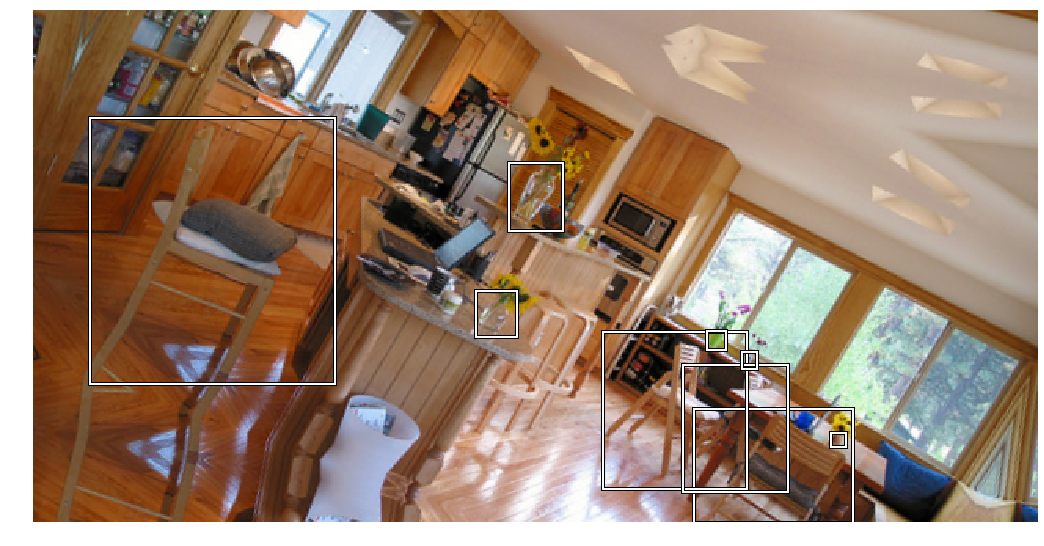

In [86]:
img = img.rotate(-20)
bbox = bbox.rotate(-20)
img.show(figsize=(18,12), y=bbox)

In [88]:
lbl_bbox[3]

[[[188.44, 86.16, 326.0, 186.57],
  [166.67, 494.67, 264.6, 555.41],
  [157.46, 413.01, 238.89000000000001, 471.82],
  [151.85, 464.38, 225.56, 498.94],
  [189.43, 305.09, 213.78, 321.21],
  [159.75, 538.08, 165.33, 545.7800000000001],
  [141.86, 439.03, 150.9, 447.22999999999996],
  [141.99, 464.75, 151.58, 470.11],
  [104.22, 289.51, 144.59, 305.81]],
 ['chair', 'chair', 'chair', 'chair', 'vase', 'vase', 'vase', 'vase', 'vase']]

In [93]:
bbox

array([Category chair, Category vase], dtype=object)

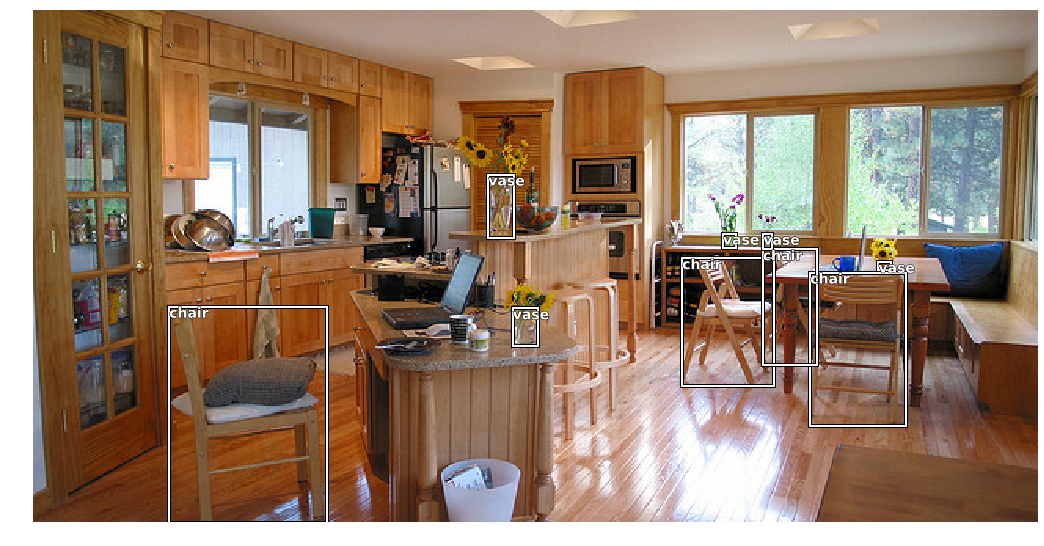

In [94]:
img = open_image(coco/'train_sample'/images[3])
bbox = ImageBBox.create(*img.size, lbl_bbox[3][0],[0,0,0,0,1,1,1,1,1],classes=['chair','vase'])
img.show(figsize=(18,12), y=bbox)

In [98]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(coco/'train_sample')
    src = src.split_by_rand_pct()
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=coco, bs=bs, collate_fn=bb_pad_collate)

In [99]:
data = get_data(64,128)

In [100]:
data

ImageDataBunch;

Train: LabelList (17470 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /home/ec2-user/.fastai/data/coco_sample/train_sample;

Valid: LabelList (4367 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /home/ec2-user/.fastai/data/coco_sample/train_sample;

Test: None

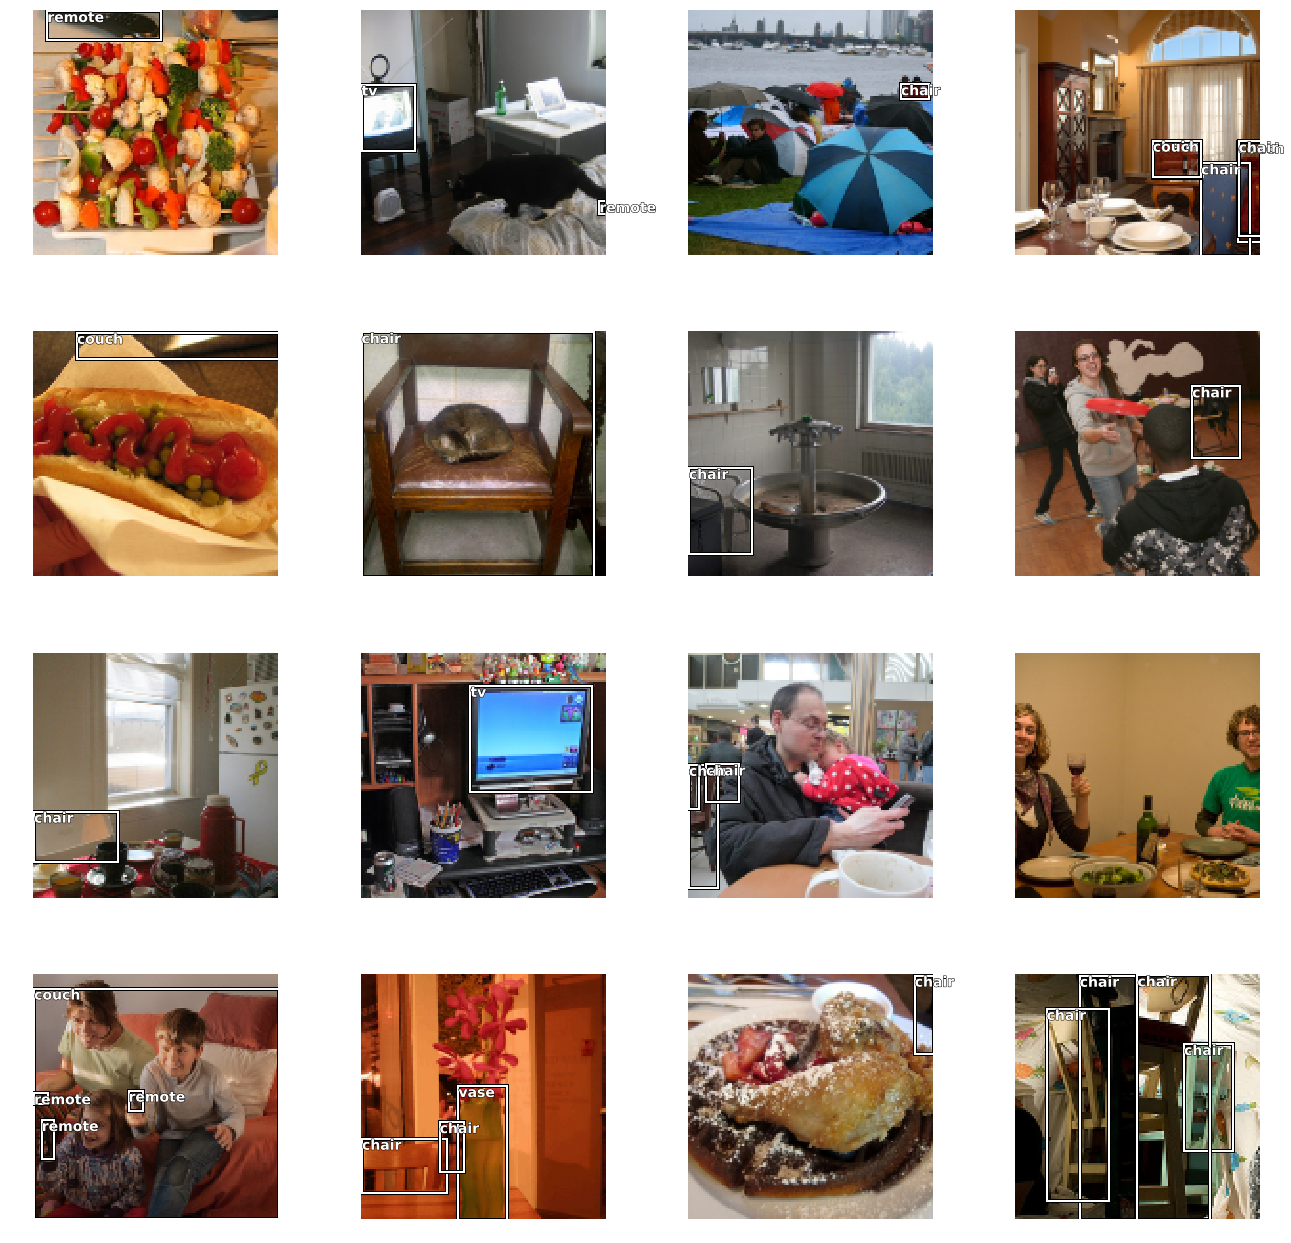

In [102]:
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(18,18))

Trying Again on xView

We need to create a new json file with categories, annoations, images

In [ ]:
images, lbl_bbox = get_annotations(coco/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [103]:
??get_annotations

Signature: get_annotations(fname, prefix=None)
Source:   
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {}
    for o in annot_dict['categories']:
        classes[o['id']] = o['name']
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[1],bb[0], bb[3]+bb[1], bb[2]+bb[0]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    for o in annot_dict['images']:
        if o['id'] in id2bboxes:
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]
File:      ~/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/vision/data.p

Before using this dataset, we need to perform some data cleaning. The algorithm expects the dataset in a particular JSON format. The xView dataset, while containing annotations in JSON, does not follow our specifications. We will use this as an opportunity to introduce our JSON format by performing this convertion. To begin with we create appropriate directories for training images, validation images, as well as the annotation files for both.

### Prepare dataset 

The Amazon SageMaker Object Detection algorithm expects lables to be indexed from `0`. It also expects lables to be unique, successive and not skip any integers. For instance, if there are ten classes, the algorithm expects and the labels only be in the set `[0,1,2,3,4,5,6,7,8,9]`. 

In the xView validation set unfortunately, the labels do not satistify this requirement. Some indices are skipped and the labels start from `1`. We therefore need a mapper that will convert this index system to our requirement. Let us create a generic mapper therefore that could also be used to other datasets that might have nonunique or even string labels. All we need in a dictionary that would create a key-value mapping where an original label is hashed to a label that we require.

In [9]:
!mkdir jpeg_images

In [13]:
# Convert tiff to jpeg images
import os
from PIL import Image
from pathlib import Path

p = "./data/train_images"
img_files = []
for infile in os.listdir("./data/train_images"):
    if infile[-3:] == "tif" or infile[-3:] == "bmp" :
        
        try:
            outfile = './data/jpeg_images/' + infile[:-3] + "jpeg"
            im = Image.open(p + '/' + infile)
            out = im.convert("RGB")
            out.save(outfile, "JPEG", quality=80)
            img_files.append(outfile)
            print('saved - ',outfile)
        except:
            print('failed - ',infile)

failed
._102.tif
failed
._100.tif
failed
._109.tif


In [16]:
import os
img_files = os.listdir('./data/jpeg_images/')

In [84]:
rlist = {11:"Fixed-wing Aircraft",
         12:"Small Aircraft", 
         13:"Passenger/Cargo Plane",
         15:"Helicopter",
         17:"Passenger Vehicle",
         18:"Small Car",
         19:"Bus",
         20:"Pickup Truck",
         21:"Utility Truck",
         23:"Truck",
         24:"Cargo Truck",
         25:"Truck Tractor w/ Box Trailer",
         26:"Truck Tractor",
         27:"Trailer",
         28:"Truck Tractor w/ Flatbed Trailer",
         29:"Truck Tractor w/ Liquid Tank",
         32:"Crane Truck",
         33:"Railway Vehicle",
         34:"Passenger Car",
         35:"Cargo/Container Car",
         36:"Flat Car",
         37:"Tank car",
         38:"Locomotive",
         40:"Maritime Vessel",
         41:"Motorboat",
         42:"Sailboat",
         44:"Tugboat",
         45:"Barge",
         47:"Fishing Vessel",
         49:"Ferry",
         50:"Yacht",
         51:"Container Ship",
         52:"Oil Tanker",
         53:"Engineering Vehicle",
         54:"Tower crane",
         55:"Container Crane",
         56:"Reach Stacker",
         57:"Straddle Carrier",
         59:"Mobile Crane",
         60:"Dump Truck",
         61:"Haul Truck",
         62:"Scraper/Tractor",
         63:"Front loader/Bulldozer",
         64:"Excavator",
         65:"Cement Mixer",
         66:"Ground Grader",
         71:"Hut/Tent",
         72:"Shed",
         73:"Building",
         74:"Aircraft Hangar",
         75:"Unknown",
         76:"Damaged Building",
         77:"Facility",
         79:"Construction Site",
         82:"Unknown",
         83:"Vehicle Lot",
         84:"Helipad",
         86:"Storage Tank",
         89:"Shipping container lot",
         91:"Shipping Container",
         93:"Pylon",
         94:"Tower"}

def get_mapper():
    original_list = [11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33,
                    34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 54,
                    55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 71, 72, 73, 74, 75, 76, 77, 79, 82, 83, 84,
                    86, 89, 91, 93, 94]
    iter_counter = 0
    xView = {}
    for orig in original_list:
        xView[orig] = iter_counter
        iter_counter += 1
    return xView

Let us use this dictionary, to create a look up method. Let us do so in a way that any dictionary could be used to create this method.

In [6]:
def get_mapper_fn(map):  
    def mapper(in_category):
        return map[in_category]
    return mapper

fix_index_mapping = get_mapper_fn(get_mapper())

The method `fix_index_mapping` is essentially a look-up method, which we can use to convert lables. Let us now iterate over every annotation in the dataset and prepare our data. Note how the keywords are created and a structure is established. For more information on the JSON format details, refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

In [8]:
!pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install -U scikit-image

Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.16.2)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import data_utilities.wv_util as wv
import data_utilities.aug_util as aug

coords, chips, classes = wv.get_labels('./data/xView_train.geojson')

100%|██████████| 601937/601937 [00:02<00:00, 215882.30it/s]


In [115]:
t = coords[chips=='1127.tif']

In [136]:
t.shape

(3816, 4)

In [143]:
a = np.concatenate((np.reshape(np.array(c_classes),(3816,1)),t),axis=1)

In [145]:
a

array([[  73., 3711., 2929., 3896., 3015.],
       [  73., 3521., 2949., 3673., 3044.],
       [  73., 3653., 2937., 3873., 3061.],
       ...,
       [  12., 2344., 2579., 2382., 2614.],
       [  63., 3863.,  699., 3891.,  715.],
       [  59., 2553., 1244., 2573., 1264.]])

In [109]:
c_classes = classes[chips=='1127.tif'].astype(np.int64)

In [138]:
np.reshape(np.array(c_classes),(3816,1)).shape

(3816, 1)

In [114]:
[c_classes, coords[chips=='1127.tif']]

[array([73, 73, 73, ..., 12, 63, 59]), array([[3711., 2929., 3896., 3015.],
        [3521., 2949., 3673., 3044.],
        [3653., 2937., 3873., 3061.],
        ...,
        [2344., 2579., 2382., 2614.],
        [3863.,  699., 3891.,  715.],
        [2553., 1244., 2573., 1264.]])]

In [36]:
!mkdir ./data/jpeg_chips
!mkdir ./data/generated

mkdir: cannot create directory ‘./data/jpeg_chips’: File exists


In [183]:
img_files = ['1127.jpeg']

In [191]:
import os
import numpy as np
from PIL import Image
import json

for i in range(len(img_files)):

    arr = wv.get_image('./data/jpeg_images/'+img_files[i])
    match_name = img_files[i].strip('.jpeg')+'.tif'
    c_coords = coords[chips==match_name]
    c_classes = classes[chips==match_name].astype(np.int64)
    c_img, c_box, c_cls = wv.chip_image(img = arr, coords= c_coords, classes=c_classes, shape=(500,500))

    for j in range(len(c_img)):
        if(len(c_cls) >= 1 and c_cls[j][0] !=0):
            save_name = img_files[i].strip('.jpeg') + "_" + str(j) + '.jpeg'
            chip = Image.fromarray(c_img[j])
            chip.save('./data/jpeg_chips/' + save_name)
    
            jsonFile = save_name.strip('.jpeg')+'.json'

            line = {}
            line['file'] = save_name
            line['image_size'] = [{
                'width':500,
                'height':500,
                'depth':3
            }]
    
            line['annotations'] = []
            line['categories'] = []

#             for k in range(len(c_box[j])):
#                 line['annotations'].append({
#                     'class_id':int(fix_index_mapping(c_cls[j][k])),
#                     'top':int(c_box[j][k][0]),
#                     'left':int(c_box[j][k][1]),
#                     'width':int(c_box[j][k][2]),
#                     'height':int(c_box[j][k][3])
#                 })
#                 line['categories'].append({
#                     'class_id':int(fix_index_mapping(c_cls[j][k])),
#                     'name':rlist.get(c_cls[j][k])
#                 })
    
            for k in range(len(c_box[j])):
                line['annotations'].append({
                    'class_id':int(fix_index_mapping(c_cls[j][k])),
                    'top':int(c_box[j][k][1]),
                    'left':int(c_box[j][k][0]),
                    'width':int(c_box[j][k][2]-c_box[j][k][0]),
                    'height':int(c_box[j][k][3]-c_box[j][k][1])
                })
                line['categories'].append({
                    'class_id':int(fix_index_mapping(c_cls[j][k])),
                    'name':rlist.get(c_cls[j][k])
                })    
            with open(os.path.join('./data/generated', jsonFile),'w') as p:
                json.dump(line,p)

In [40]:

jsons = os.listdir('generated')

print ('There are {} annotation files'.format(len(jsons)))

FileNotFoundError: [Errno 2] No such file or directory: 'generated'

In [41]:
len(os.listdir('./data/generated/'))

14673

In [59]:
file_names = []
path = './data/jpeg_chips/'

folder = os.fsencode(path)

for file in os.listdir(folder):
    filename = os.fsdecode(file)
    file_names.append(filename)

After removing the images without annotations, we have 6432 annotated images. Let us split this dataset and create our training and validation datasets, with which our algorithm will train. To do so, we will simply split the dataset into training and validation data and move them to their respective folders.

In [45]:
len(file_names)

14673

In [60]:
from sklearn.model_selection import train_test_split

train = 0.8
train_list,val_list= train_test_split(file_names,train_size=train,random_state=1234)

In [52]:
!mkdir './data/train/'
!mkdir './data/train_annotation'
!mkdir './data/validation/'
!mkdir './data/validation_annotation/'

In [61]:
file_names


['1193_15.jpeg',
 '42_0.jpeg',
 '203_28.jpeg',
 '325_15.jpeg',
 '47_4.jpeg',
 '1465_36.jpeg',
 '756_4.jpeg',
 '1910_5.jpeg',
 '2542_14.jpeg',
 '1690_4.jpeg',
 '1095_8.jpeg',
 '5_13.jpeg',
 '2436_26.jpeg',
 '1124_11.jpeg',
 '2011_21.jpeg',
 '2305_10.jpeg',
 '2032_22.jpeg',
 '1831_24.jpeg',
 '145_22.jpeg',
 '871_40.jpeg',
 '1701_11.jpeg',
 '1985_19.jpeg',
 '92_10.jpeg',
 '629_15.jpeg',
 '2398_8.jpeg',
 '2370_14.jpeg',
 '805_4.jpeg',
 '73_17.jpeg',
 '2497_14.jpeg',
 '2012_45.jpeg',
 '1124_6.jpeg',
 '1912_24.jpeg',
 '379_24.jpeg',
 '1795_25.jpeg',
 '1509_29.jpeg',
 '2214_9.jpeg',
 '1284_12.jpeg',
 '128_18.jpeg',
 '2371_14.jpeg',
 '1128_33.jpeg',
 '1932_48.jpeg',
 '2542_19.jpeg',
 '105_17.jpeg',
 '1181_12.jpeg',
 '5_12.jpeg',
 '2519_20.jpeg',
 '112_30.jpeg',
 '2515_12.jpeg',
 '805_8.jpeg',
 '1403_30.jpeg',
 '1431_13.jpeg',
 '1150_23.jpeg',
 '1807_5.jpeg',
 '1807_34.jpeg',
 '1245_20.jpeg',
 '523_7.jpeg',
 '42_13.jpeg',
 '1441_9.jpeg',
 '1061_27.jpeg',
 '1472_10.jpeg',
 '2565_39.jpeg',
 '18_1

In [63]:
import shutil

#Moving training files to the training folders
for i in train_list:
    if '.jpeg' in i:
        image_file = './data/jpeg_chips/'+i
        shutil.copy(image_file, './data/train/')
        shutil.copy('./data/generated/'+i.strip('.jpeg')+'.json', './data/train_annotation/')

#Moving validation files to the validation folders
for i in val_list:
    if '.jpeg' in i:
        image_file = './data/jpeg_chips/'+i
        shutil.copy(image_file, './data/validation/')
        shutil.copy('./data/generated/'+i.strip('.jpeg')+'.json', './data/validation_annotation/')

### Upload to S3
Next step in this process is to upload the data to the S3 bucket, from which the algorithm can read and use the data. We do this using multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories `train` and `validation`. We will therefore require four channels: two for the data and two for annotations, the annotations ones named with the suffixes `_annotation`.

In [65]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='./data/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='./data/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='./data/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='./data/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 2min 42s, sys: 10.2 s, total: 2min 53s
Wall time: 32min 23s


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [67]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [68]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.p3.8xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000, 
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `30` epochs.

In [75]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=62,
                             mini_batch_size=8,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=500,
                             label_width=6000,
                             num_training_samples=300)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes. Notice that here we use a `content_type` as `image/jpeg` for the image channels and the annoation channels. Notice how unlike the [RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb), we use four channels here.

In [76]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following cell will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [77]:
od_model.fit(inputs=data_channels, logs=True)

2020-04-07 13:47:54 Starting - Starting the training job...
2020-04-07 13:47:56 Starting - Launching requested ML instances......
2020-04-07 13:48:59 Starting - Preparing the instances for training......
2020-04-07 13:50:16 Downloading - Downloading input data...........................
2020-04-07 13:54:53 Training - Downloading the training image...
2020-04-07 13:55:13 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[04/07/2020 13:55:11 INFO 140246866417472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_pat

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [78]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

---------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. 

In [177]:
file_name = './data/jpeg_images/1127.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    #ne = open('n.txt','wb')
    #ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [181]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[49.0, 0.24397997558116913, 0.3898436427116394, 0.2477450966835022, 0.9004295468330383, 0.9261294007301331], [49.0, 0.23961712419986725, 0.06755027174949646, 0.3047883212566376, 0.7221823930740356, 0.982193112373352], [49.0, 0.2208821177482605, 0.1825352907180786, 0.4953910708427429, 0.9380156993865967, 0.8057736754417419], [49.0, 0.19728399813175201, 0.20619018375873566, 0.22607412934303284, 0.42882072925567627, 0.8652743101119995], [49.0, 0.19638673961162567, 0.5702306628227234, 0.5668306350708008, 0.8566215634346008, 0.8650689125061035], [49.0, 0.1932336837053299, 0.1580875813961029, 0.7293457984924316, 0.9696768522262573, 1.0], [49.0, 0.1929304152727127, 0.7534295916557312, 0.25554367899894714, 1.0, 0.5718234777450562], [49.0, 0.19255468249320984, 0.09169413149356842, 0.23092567920684814, 0.291670024394989, 0.9018343687057495], [49.0, 0.1823461502790451, 0.7061944007873535, 0.0027247071266174316, 0.9264174699783325, 0.6082537174224854], [49.0, 0.18174128234386444, 0

The results are in a format that is similar to the input .lst file (See [RecordIO Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) for more details on the .lst file definition. )with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [192]:
def visualize_chip(img_file, dets, classes=[]):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(img)
        height = 1#img.shape[0]
        width = 1#img.shape[1]
        colors = dict()
        for det in dets['annotations']:
            print(det)
            klass = det['class_id']
            y0 = det['top']
            x0 = det['left']
            width = det['width']
            height = det['height']
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())

            rect = plt.Rectangle((x0, y0), width,
                                 height, fill=False,
                                 edgecolor='red',
                                 linewidth=3.5)
            plt.gca().add_patch(rect)

        plt.show()

In [179]:
def visualize_detection(img_file, dets, classes=[], thresh=0.5):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            print(det)
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
#             rect = plt.Rectangle((xmin, ymin), xmax - xmin,
#                                  ymax - ymin, fill=False,
#                                  edgecolor=colors[cls_id],
#                                  linewidth=3.5)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)

        plt.show()

In [153]:
def visualize_training(img_file, img_class, img_bbox, classesclasses=[]):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        
        img=mpimg.imread(img_file)
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(img)
        height = 1#img.shape[0]
        width = 1#img.shape[1]
        colors = dict()
        
        for p,det in enumerate(img_bbox):
            (x0, y0, x1, y1) = det
            klass = img_class[p]
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor='red',
                                 linewidth=3.5)
            plt.gca().add_patch(rect)

        plt.show()

To achieve better detection results, you can try to use the more data from the dataset and train the model for more epochs. Tuning the hyperparameters, such as `mini_batch_size`, `learning_rate`, and `optimizer`, also helps to get a better detector.

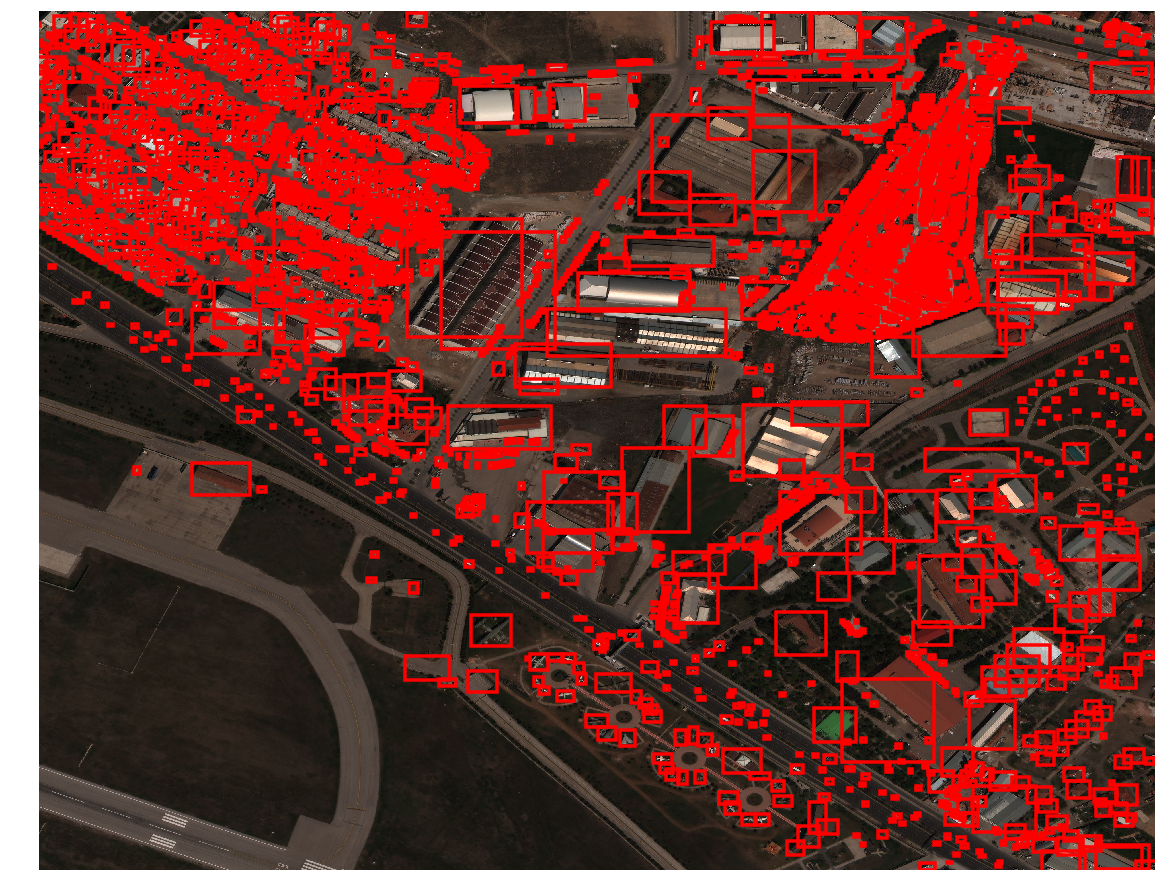

In [174]:
file_name = './data/jpeg_images/1127.jpeg'
fclasses = classes[chips==file_name.split('/')[-1].strip('.jpeg') + '.tif'].astype(np.int64)
fbbox = coords[chips==file_name.split('/')[-1].strip('.jpeg') + '.tif']
visualize_training(file_name, fclasses, fbbox, list(rlist.values()))

{'class_id': 12, 'top': 0, 'left': 331, 'width': 56, 'height': 11}
{'class_id': 5, 'top': 47, 'left': 267, 'width': 20, 'height': 13}
{'class_id': 5, 'top': 128, 'left': 381, 'width': 15, 'height': 10}
{'class_id': 5, 'top': 127, 'left': 405, 'width': 14, 'height': 11}
{'class_id': 5, 'top': 167, 'left': 421, 'width': 18, 'height': 12}
{'class_id': 5, 'top': 187, 'left': 479, 'width': 17, 'height': 13}
{'class_id': 5, 'top': 193, 'left': 463, 'width': 16, 'height': 12}
{'class_id': 5, 'top': 214, 'left': 477, 'width': 18, 'height': 13}
{'class_id': 12, 'top': 213, 'left': 448, 'width': 44, 'height': 28}
{'class_id': 5, 'top': 236, 'left': 468, 'width': 18, 'height': 14}
{'class_id': 2, 'top': 120, 'left': 14, 'width': 141, 'height': 109}
{'class_id': 2, 'top': 257, 'left': 224, 'width': 62, 'height': 59}
{'class_id': 1, 'top': 259, 'left': 286, 'width': 51, 'height': 23}
{'class_id': 0, 'top': 330, 'left': 456, 'width': 44, 'height': 62}
{'class_id': 0, 'top': 474, 'left': 418, 'width'

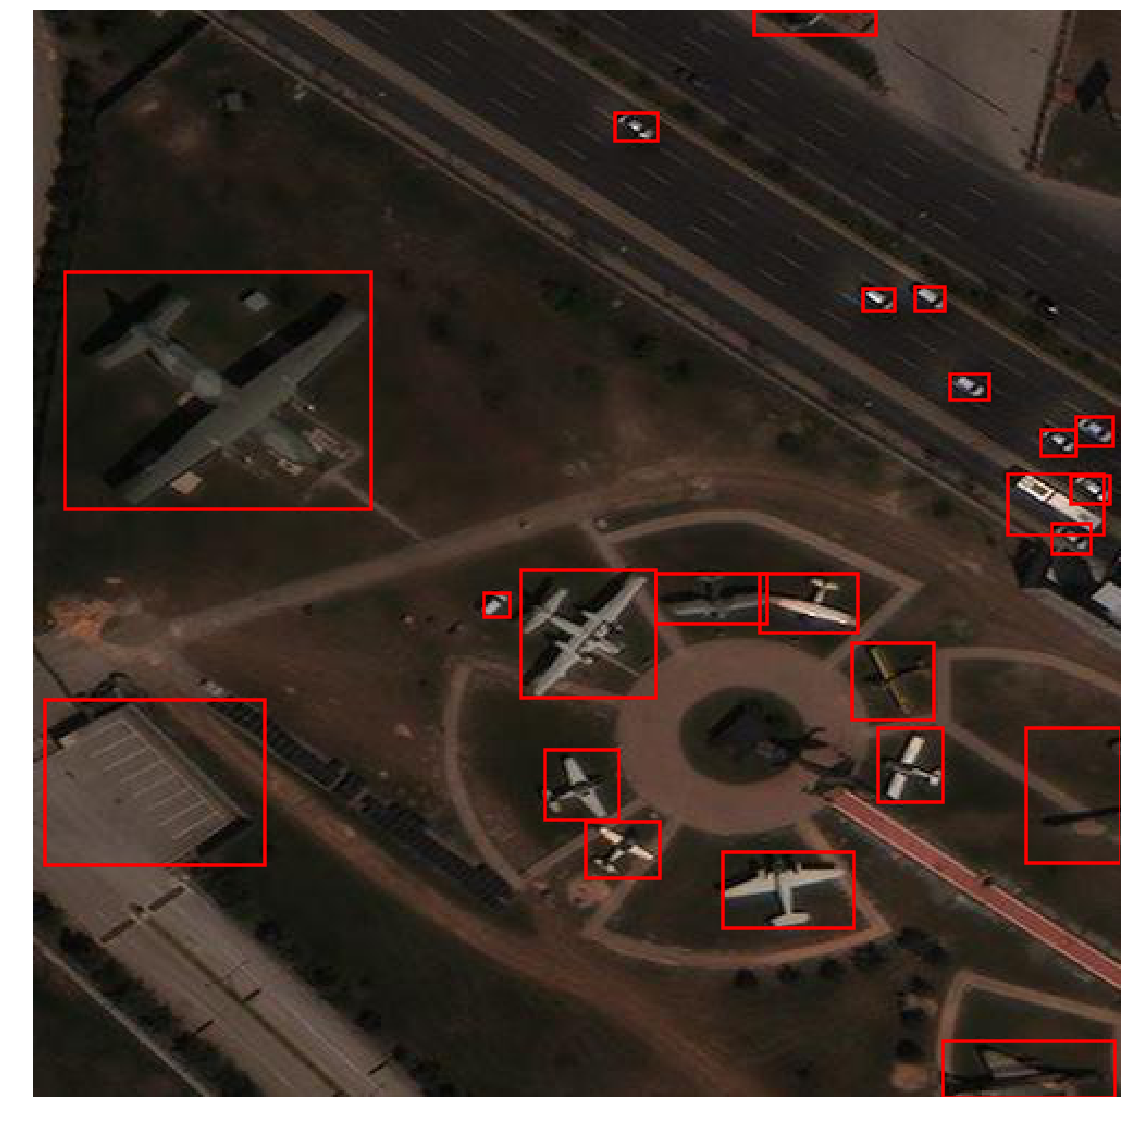

In [193]:
file_name = './data/jpeg_chips/1127_22.jpeg'

import json
with open('./data/generated/1127_22.json') as f:
  chip_data = json.load(f)

visualize_chip(file_name, chip_data, list(rlist.values()))

In [185]:

import json
with open('./data/generated/1127_22.json') as f:
  data = json.load(f)

print(data['annotations'])

visualize_chip(img_file, dets, list(rlist.values()))

[{'class_id': 12, 'top': 331, 'left': 0, 'width': 56, 'height': 11}, {'class_id': 5, 'top': 267, 'left': 47, 'width': 20, 'height': 13}, {'class_id': 5, 'top': 381, 'left': 128, 'width': 15, 'height': 10}, {'class_id': 5, 'top': 405, 'left': 127, 'width': 14, 'height': 11}, {'class_id': 5, 'top': 421, 'left': 167, 'width': 18, 'height': 12}, {'class_id': 5, 'top': 479, 'left': 187, 'width': 17, 'height': 13}, {'class_id': 5, 'top': 463, 'left': 193, 'width': 16, 'height': 12}, {'class_id': 5, 'top': 477, 'left': 214, 'width': 18, 'height': 13}, {'class_id': 12, 'top': 448, 'left': 213, 'width': 44, 'height': 28}, {'class_id': 5, 'top': 468, 'left': 236, 'width': 18, 'height': 14}, {'class_id': 2, 'top': 14, 'left': 120, 'width': 141, 'height': 109}, {'class_id': 2, 'top': 224, 'left': 257, 'width': 62, 'height': 59}, {'class_id': 1, 'top': 286, 'left': 259, 'width': 51, 'height': 23}, {'class_id': 0, 'top': 456, 'left': 330, 'width': 44, 'height': 62}, {'class_id': 0, 'top': 418, 'left

NameError: name 'img_file' is not defined

In [158]:
j = data['annotations']

In [160]:
j[1]['class_id']

5

[49.0, 0.24397997558116913, 0.3898436427116394, 0.2477450966835022, 0.9004295468330383, 0.9261294007301331]
[49.0, 0.23961712419986725, 0.06755027174949646, 0.3047883212566376, 0.7221823930740356, 0.982193112373352]
[49.0, 0.2208821177482605, 0.1825352907180786, 0.4953910708427429, 0.9380156993865967, 0.8057736754417419]
[49.0, 0.19728399813175201, 0.20619018375873566, 0.22607412934303284, 0.42882072925567627, 0.8652743101119995]
[49.0, 0.19638673961162567, 0.5702306628227234, 0.5668306350708008, 0.8566215634346008, 0.8650689125061035]
[49.0, 0.1932336837053299, 0.1580875813961029, 0.7293457984924316, 0.9696768522262573, 1.0]
[49.0, 0.1929304152727127, 0.7534295916557312, 0.25554367899894714, 1.0, 0.5718234777450562]
[49.0, 0.19255468249320984, 0.09169413149356842, 0.23092567920684814, 0.291670024394989, 0.9018343687057495]
[49.0, 0.1823461502790451, 0.7061944007873535, 0.0027247071266174316, 0.9264174699783325, 0.6082537174224854]
[49.0, 0.18174128234386444, 0.023200184106826782, 0.03

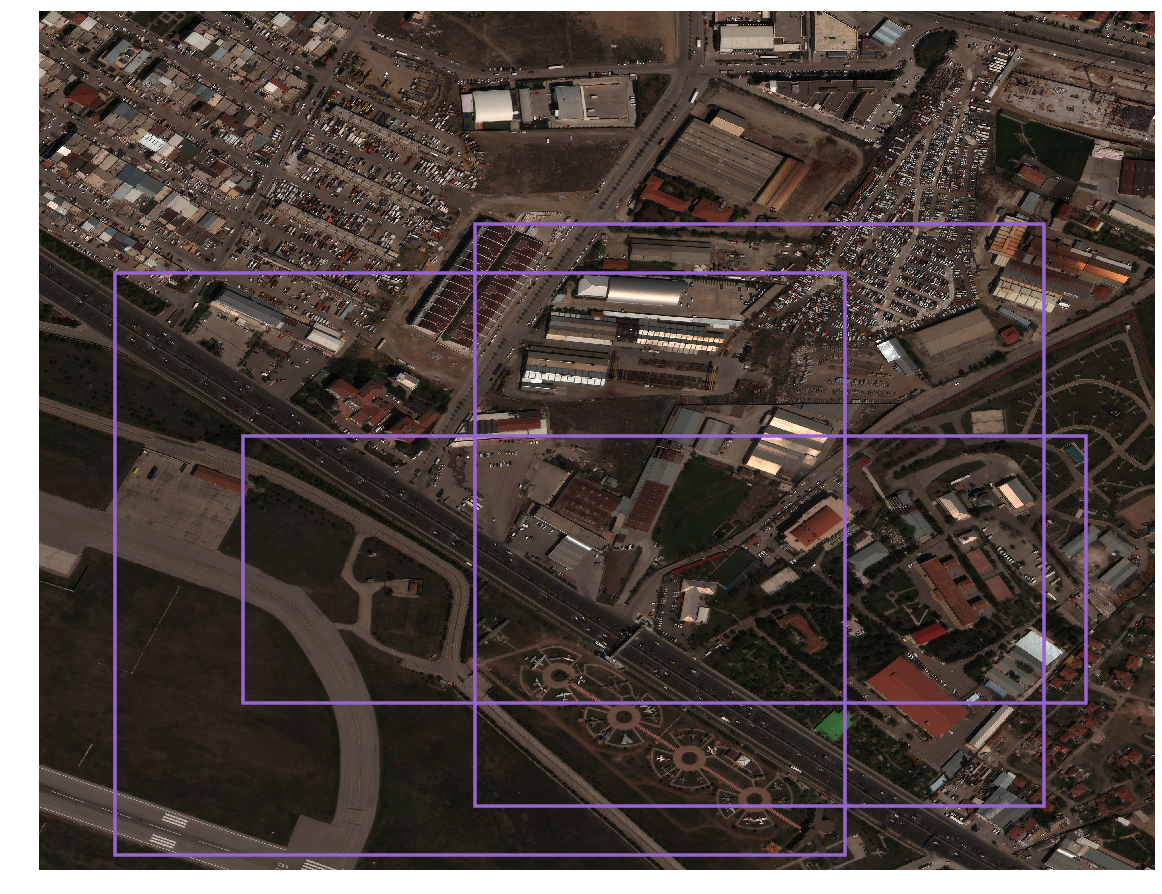

In [180]:
%matplotlib inline

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], list(rlist.values()), threshold)

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)